# Filterbank

This notebook shares the code for building the filter bank in pytf.

In [1]:
import os, sys
path = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt

from mu import core
from mu import FilterBank

from mspacman.generator.noise import (white, pink) # I can't share this repository yet until my paper is published.
# So in order to make this example to work on your local machine, try generating your own test signal.

## Generate Signal

In [2]:
# Properties
tdur = 20
fs = 30000
nsamp = fs * tdur

# f = np.linspace(0, 100, nsamp)
f = 100

# Generate a time domain signal
t = np.linspace(0, tdur, nsamp)
x = np.sin(f * 2 * np.pi * t)

amp = .5
noise = (white(nsamp, mean=0, std=amp) + pink(nsamp, mean=0, std=amp)).flatten()

xn = x + noise

# Convert generated signal to frequency domain
X = np.fft.rfft(x, axis=-1)
Xn = np.fft.rfft(xn, axis=-1)
w = np.fft.rfftfreq(xn.size) * fs

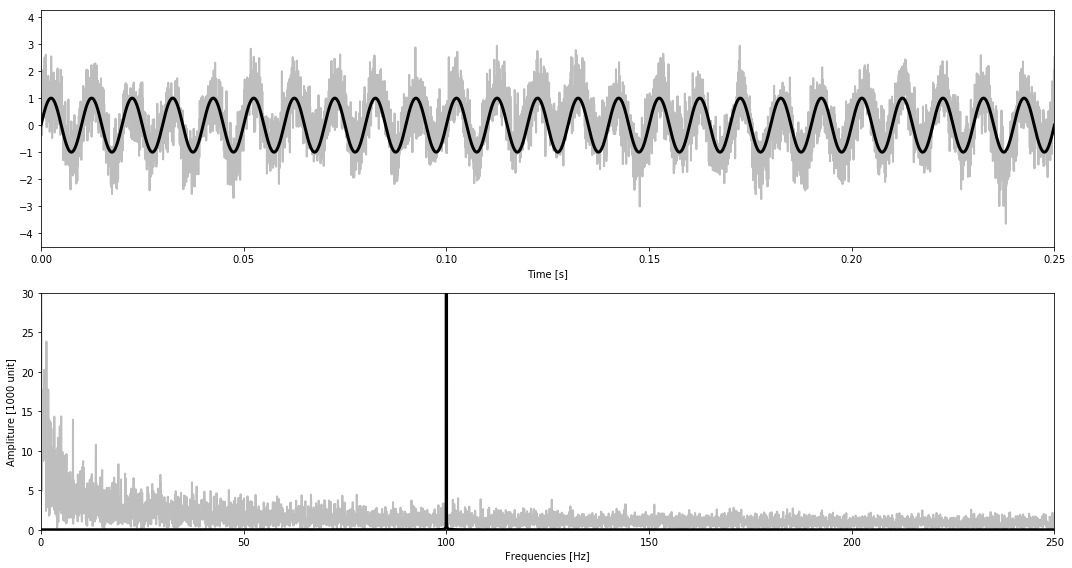

In [3]:
figs, axs = plt.subplots(2, 1, figsize=(15, 8))

axs[0].plot(t, xn, c='C7', lw=2, alpha=.5)
axs[0].plot(t, x, c='k', lw=3)
axs[0].set_xlim([0, 0.25])
axs[0].set_xlabel('Time [s]')

scale = 1E-3
axs[1].plot(w, np.abs(Xn) * scale, c='C7', lw=2, alpha=.5)
axs[1].plot(w, np.abs(X) * scale, c='k', lw=3)
axs[1].set_xlim([0, 250])
axs[1].set_ylim([0, 30])
axs[1].set_xlabel('Frequencies [Hz]')
axs[1].set_ylabel('Ampliture [{} unit]'.format(int(1/scale)))
plt.tight_layout()

15000.0 30000
(2049,)


(0, 250)

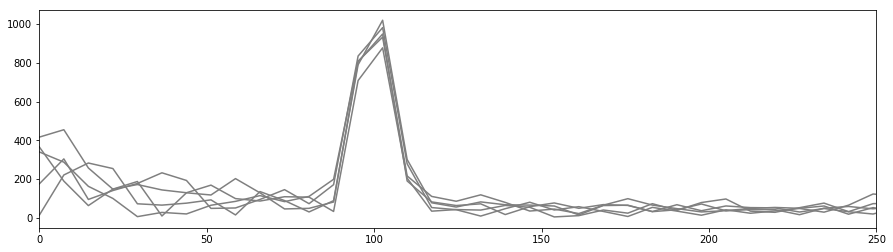

In [4]:
mode = None
from mu import time_frequency as tf
binsize = 2**12
hopsize = binsize // 2

if mode is 'full':
    fftfreq_ = np.fft.fftfreq
else:
    fftfreq_ = np.fft.rfftfreq
    
Xn_ = tf.stft.stft(xn, binsize=binsize, hopsize=hopsize, window='hanning', mode=mode)
wn_ = fftfreq_(binsize) * fs

print(wn_[-1], fs)
print(np.abs(Xn_)[0,0,:].shape)
plt.figure(figsize=(15, 4))
plt.plot(wn_, np.abs(Xn_)[0,:5,:].T, c='C7')
plt.xlim([0, 250])

Text(0, 0.5, 'Frequencies [Hz]')

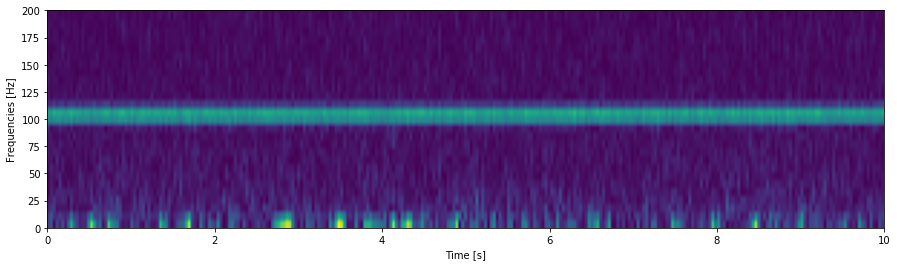

In [5]:
plt.figure(figsize=(15, 4))
plt.imshow(np.abs(Xn_)[0,:,:binsize//2].T,
           aspect='auto',
           origin='lower',
           interpolation='hanning',
           extent=[0, 10, 0, fs//2])

# plt.xlim([0, 5])
plt.ylim([0, 200])
plt.xlabel('Time [s]')
plt.ylabel('Frequencies [Hz]')

### Fancy Indexing

In [6]:
zero_phase = True
center_freqs = np.array([100, 300, 600])
# center_freqs = np.array([100])
bandwidth = 100
freq_bands = None
# Initialize the filter bank class
fb = FilterBank(nch=1, nsamp=nsamp, binsize=binsize, decimate_by=1, \
                bandwidth=bandwidth, center_freqs=center_freqs, freq_bands=freq_bands, order=binsize, sample_rate=fs, \
                hilbert=False, domain='time', nprocs=1, mprocs=False,
                logger=None)

w_, filts_ = fb._create_prototype_filter(shift=True, output='freq')

if zero_phase:
    filts_*=filts_

Text(0, 0.5, 'Frequencies [Hz]')

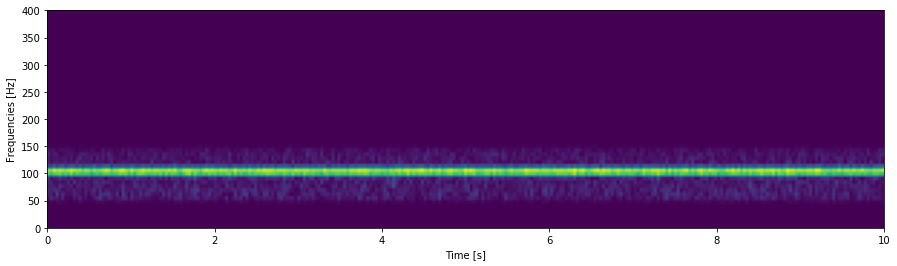

In [7]:
nfreqs = fb._fidx.shape[0]
tmpX = np.concatenate([np.zeros_like(Xn_) for ix in range(nfreqs)], axis=0)
tmpX[fb._idx2,:,fb._idx1] = (Xn_[0,:,fb._idx1].T * filts_[fb._fidx].T).T

plt.figure(figsize=(15, 4))
plt.imshow(np.abs(tmpX)[0,:,:binsize//2].T,
           aspect='auto',
           origin='lower',
           interpolation='hanning',
           extent=[0, 10, 0, fs//2])

plt.ylim([0, 400])
plt.xlabel('Time [s]')
plt.ylabel('Frequencies [Hz]')

### Overlap-add filtering

In [8]:
_delay = None if zero_phase else fb.delay_

tmpx = tf.stft.istft(tmpX, binsize=binsize, hopsize=hopsize, axis=-1, mode=mode, delay=_delay).real
xi = tf.stft.istft(Xn_, bin
                   size=binsize, hopsize=hopsize, axis=-1, mode=mode).real

In [9]:
def olaf(x, F, binsize, hopsize, idx1, idx2, fidx, mode, delay):
    _X = tf.stft.stft(x, binsize=binsize, hopsize=hopsize, window='hanning', mode=mode)
    _Xf = np.concatenate([np.zeros_like(_X) for ix in range(fidx.shape[0])], axis=0)
    _Xf[idx2,:,idx1] = (_X[0,:,idx1].T * F[fidx].T).T
    return tf.stft.istft(_Xf, binsize=binsize, hopsize=hopsize, axis=-1, mode=mode, delay=delay).real

In [10]:
tmp_xf = olaf(xn, filts_, binsize, hopsize, fb._idx1, fb._idx2, fb._fidx, mode, _delay)
# %timeit tmp_xf = olaf(xn, filts_, binsize, hopsize, fb._idx1, fb._idx2, fb._fidx, mode, _delay)

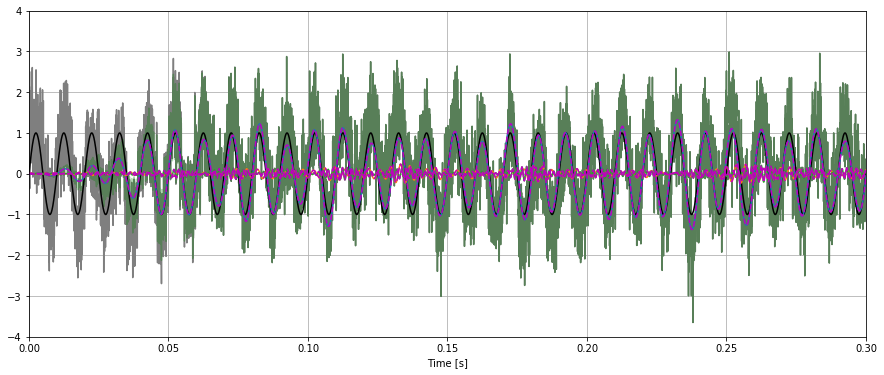

In [11]:
plt.figure(figsize=(15, 6))
plt.plot(t, xn, c='C7')
plt.plot(np.arange(xi.shape[-1])/fs, xi.flatten(), c='g', alpha=.3)
plt.plot(t, x, c='k')
plt.plot(np.arange(tmpx.shape[-1])/fs, tmpx.T)
plt.plot(np.arange(tmp_xf.shape[-1])/fs, tmp_xf.T, '--', c='m')

plt.xlim([0, 0.3])
plt.ylim([-4, 4])
plt.xlabel("Time [s]")
plt.grid(True)

### Decimation - for overlap-add

In [12]:
dec = 32
print('Downsampled Rate: ', fs / dec)

_delay_ = _delay // dec if _delay is not None else None
_binsize_ = binsize // dec
_hopsize_ = hopsize // dec

print(_binsize_, _hopsize_, _delay_, mode)

tmpX_ = tmpX[:,:,:_binsize_//2] / dec
tmpw_ = wn_[:_binsize_//2]

tmpxi = np.fft.irfft(tmpX, n=binsize, axis=-1)
tmpxi_ = np.fft.irfft(tmpX_, n=_binsize_, axis=-1)

ti = np.arange(tmpxi.shape[-1]) / fs
ti_ = np.arange(tmpxi_.shape[-1]) / (fs//dec)

Downsampled Rate:  937.5
128 64 None None


Text(0.5, 0, 'Time [s]')

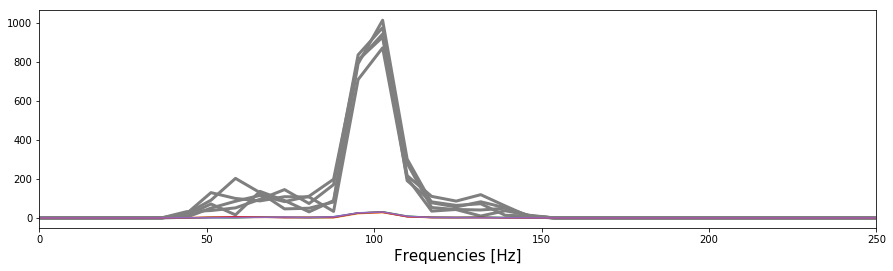

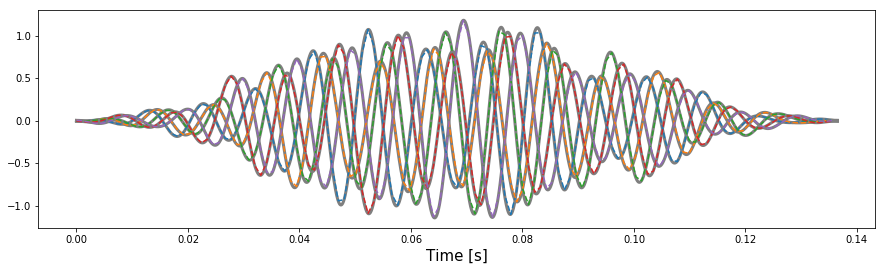

In [18]:
FONTSIZE = 15
plt.figure(figsize=(15, 4))
plt.plot(wn_, np.abs(tmpX)[0,:5,:].T, c='C7', lw=3)
plt.plot(tmpw_, np.abs(tmpX_)[0,:5,:].T)
plt.xlim([0, 250])
plt.xlabel('Frequencies [Hz]', fontsize=FONTSIZE)

ix = 3
plt.figure(figsize=(15, 4))
plt.plot(ti, tmpxi[0,:5,:].T, '-', c='C7', lw=3)
plt.plot(ti_, tmpxi_[0,:5,:].T, '--')
plt.xlabel('Time [s]', fontsize=FONTSIZE)

In [20]:
def ola_(x, binsize, hopsize, delay, n=None):
    x = np.concatenate([x[:,:,delay:], x[:,:,:delay]], axis=-1) if delay is not None else x
    overlap_factor = binsize / hopsize

    nsamps = int((x.size//x.shape[0]) / overlap_factor + binsize)
    result_xi = np.zeros((x.shape[0], nsamps+binsize), dtype=x.dtype)

    r_ = core.frame(result_xi, binsize, hopsize)
    for i in range(x.shape[1]):
        r_[:,i, :] += x[:,i, :]

    if n is None:
        return result_xi
    else:
        return result_xi[:,:n]

def olaf_(x, F, binsize, hopsize, idx1, idx2, fidx, mode, delay, dec):
    _X = tf.stft.stft(x, binsize=binsize, hopsize=hopsize, window='hanning', mode=mode)
    _Xf = np.concatenate([np.zeros_like(_X) for ix in range(fidx.shape[0])], axis=0)
    _Xf[idx2,:,idx1] = (_X[0,:,idx1].T * F[fidx].T).T
    return tf.stft.istft(_Xf/dec, binsize=binsize//dec, hopsize=hopsize//dec, axis=-1, mode=mode, delay=delay, n=binsize//dec).real

result_xi = ola_(tmpxi, binsize, hopsize, _delay, n=nsamp)
result_xi_ = ola_(tmpxi_, binsize//dec, hopsize//dec, _delay, n=nsamp)
result_xi2_ = olaf_(xn, filts_, binsize, hopsize, fb._idx1, fb._idx2, fb._fidx, mode, _delay, dec)

print("Decimating Factor ", dec)
%timeit olaf_(xn, filts_, binsize, hopsize, fb._idx1, fb._idx2, fb._fidx, mode, _delay, dec)
t_ = np.arange(result_xi_.shape[-1]) / (fs / dec)

# %timeit ola_(tmpxi, binsize, hopsize, _delay, n=nsamp)
# %timeit ola_(tmpxi_, binsize//dec, hopsize//dec, _delay, n=nsamp)

Decimating Factor  32
27 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.3 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.3 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


(-4, 4)

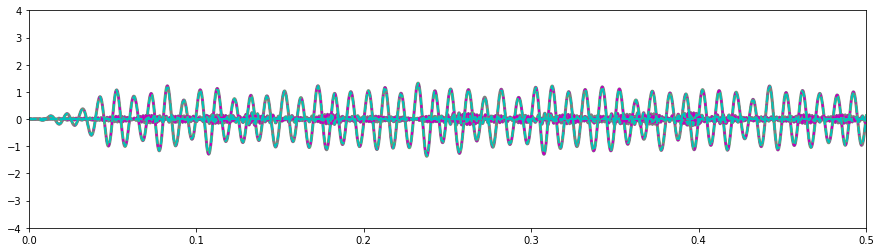

In [15]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(result_xi.shape[-1])/fs, result_xi.T, c='C7', lw=3)
plt.plot(np.arange(tmp_xf.shape[-1])/fs, tmp_xf.T, '--', c='m', lw=2)
plt.plot(t_, result_xi_.T, '--', c='y', lw=2)
plt.plot(t_, result_xi2_.T, '--', c='c', lw=2)

plt.xlim([0, .5])
plt.ylim([-4, 4])

In [16]:
Xf = np.fft.rfft(tmp_xf, axis=-1)
wf = np.fft.rfftfreq(tmp_xf.shape[-1]) * (fs)

(0, 10000)

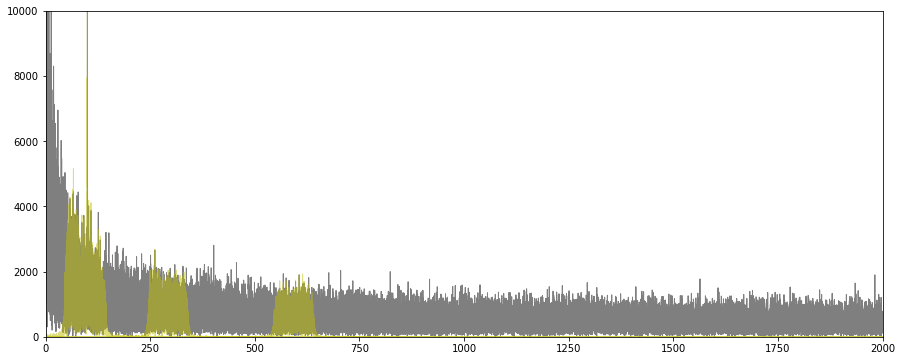

In [17]:
figs, axs = plt.subplots(1, 1, figsize=(15, 6))
axs.plot(w, np.abs(Xn).T, c='C7', alpha=1, lw=1)
axs.plot(wf, np.abs(Xf).T, c='y', alpha=.5, lw=1)
axs.set_xlim([0, 1000])
axs.set_ylim([0, 10000])